# Tomato Ripeness Inference (SVM + CIELAB)

This notebook loads your trained **svm_lab.joblib** and **label_encoder.joblib**, then classifies tomatoes from the **Laboro Tomato** dataset and **displays** the predictions on the image.

**How to use:**
1. Make sure this notebook is in the same folder as your saved model files (`svm_lab.joblib` and `label_encoder.joblib`).
2. Update `DATA_ROOT` below to your dataset path.
3. Choose which JSON to use (`train.json` or `test.json`) and set `IMG_INDEX` to pick an image.
4. Run all cells. The last cell will show the image with boxes and predicted ripeness labels.


In [1]:
%matplotlib inline
from pathlib import Path
import json
import numpy as np
import cv2
from joblib import load
import matplotlib.pyplot as plt

print("Using Python from:")
import sys; print(sys.executable)

Using Python from:
d:\Software_projects\TomatoRipeness\svm_venv\Scripts\python.exe


In [2]:
# === Paths (EDIT THESE) ===
DATA_ROOT = Path(r"C:\\Users\\ACER NITRO 5 GAMING\\.cache\\kagglehub\\datasets\\nexuswho\\laboro-tomato\\versions\\5")
ANN_JSON = "test.json"   # or "train.json"

# The annotation folder can be named 'annotations' or 'annotation'
ANN_DIR = DATA_ROOT / "annotations"
if not ANN_DIR.exists():
    ANN_DIR = DATA_ROOT / "annotation"
assert ANN_DIR.exists(), f"No annotation directory found under {DATA_ROOT}"

ann = json.loads((ANN_DIR / ANN_JSON).read_text())

# Load model + label encoder saved from training
MODEL_PATH = Path("svm_lab.joblib")
LE_PATH = Path("label_encoder.joblib")
model = load(MODEL_PATH)
le    = load(LE_PATH)
print("Loaded model:", MODEL_PATH)
print("Loaded label encoder:", LE_PATH)

# Resolve which folder has images for this split
if (DATA_ROOT / "val" / "images").exists() and ANN_JSON.startswith("test"):
    IMG_DIR = DATA_ROOT / "val" / "images"
elif (DATA_ROOT / "train" / "images").exists() and ANN_JSON.startswith("train"):
    IMG_DIR = DATA_ROOT / "train" / "images"
else:
    IMG_DIR = DATA_ROOT / "images"
    if not IMG_DIR.exists():
        IMG_DIR = DATA_ROOT / "test" / "images"
print("Using image dir:", IMG_DIR)

Loaded model: svm_lab.joblib
Loaded label encoder: label_encoder.joblib
Using image dir: C:\Users\ACER NITRO 5 GAMING\.cache\kagglehub\datasets\nexuswho\laboro-tomato\versions\5\val\images


In [3]:
# === Helper functions ===
import numpy as np
import cv2

def extract_lab_features(bgr_img, mask_bool):
    """Compute mean & std of L*, a*, b* within mask."""
    lab = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2LAB)
    if mask_bool is None:
        mask_bool = np.ones(lab.shape[:2], dtype=bool)
    if mask_bool.sum() < 10:
        return None
    L = lab[:,:,0][mask_bool].astype(np.float32)
    a = lab[:,:,1][mask_bool].astype(np.float32)
    b = lab[:,:,2][mask_bool].astype(np.float32)
    return np.array([
        float(L.mean()), float(L.std()+1e-6),
        float(a.mean()), float(a.std()+1e-6),
        float(b.mean()), float(b.std()+1e-6),
    ], dtype=np.float32)

def bbox_to_mask(h, w, bbox):
    x,y,bw,bh = bbox
    x0,y0,x1,y1 = int(x), int(y), int(x+bw), int(y+bh)
    m = np.zeros((h,w), dtype=bool)
    m[y0:y1, x0:x1] = True
    return m

Image path: C:\Users\ACER NITRO 5 GAMING\.cache\kagglehub\datasets\nexuswho\laboro-tomato\versions\5\val\images\IMG_1122.jpg
Found 20 annotation(s) in this image
Predicted labels: [np.str_('half_ripened'), np.str_('half_ripened'), np.str_('half_ripened'), np.str_('green'), np.str_('green'), np.str_('green'), np.str_('green'), np.str_('green'), np.str_('green'), np.str_('green'), np.str_('green'), np.str_('green'), np.str_('green'), np.str_('green'), np.str_('green'), np.str_('green'), np.str_('green'), np.str_('green'), np.str_('green'), np.str_('green')]


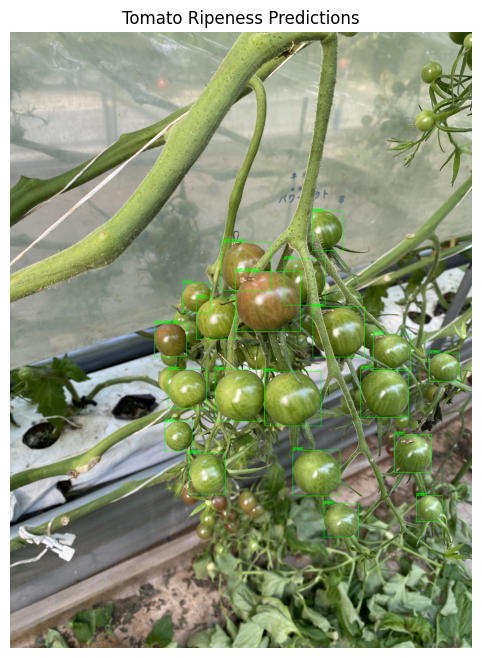

In [4]:
# === Pick an image by index and classify all tomatoes in it ===
IMG_INDEX = 0   # <-- change this index to see other images

img_info = ann["images"][IMG_INDEX]
img_path = IMG_DIR / img_info["file_name"]
print("Image path:", img_path)
im = cv2.imread(str(img_path))
assert im is not None, f"Could not read image: {img_path}"

# All annotations for this image
anns_for_img = [a for a in ann["annotations"] if a["image_id"] == img_info["id"]]
print(f"Found {len(anns_for_img)} annotation(s) in this image")

# Predict label for each annotation and draw it
im_draw = im.copy()
predictions = []
for a in anns_for_img:
    H, W = im.shape[:2]
    mask = bbox_to_mask(H, W, a["bbox"])  # using bbox mask; swap with your polygon mask if available
    feats = extract_lab_features(im, mask)
    if feats is None:
        continue
    pred_idx = model.predict(feats.reshape(1,-1))[0]
    pred_label = le.inverse_transform([pred_idx])[0]
    predictions.append(pred_label)
    x,y,bw,bh = map(int, a["bbox"])
    cv2.rectangle(im_draw, (x,y), (x+bw, y+bh), (0,255,0), 2)
    cv2.putText(im_draw, pred_label, (x, max(10,y-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2, cv2.LINE_AA)

print("Predicted labels:", predictions if predictions else "<none>")

# Display (convert BGR->RGB for matplotlib)
im_rgb = cv2.cvtColor(im_draw, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,8))
plt.imshow(im_rgb)
plt.axis('off')
plt.title('Tomato Ripeness Predictions')
plt.show()